## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_05-08-06-23.csv', firstRow=564, lastRow=570)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_050623_S565-570.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=80s and ended at t=480s; mass=43.803050000000006g
This equals a volume of 43.891m; expected was 44.463mL; error is 1.287%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0002 g/s^2


<IPython.core.display.Javascript object>


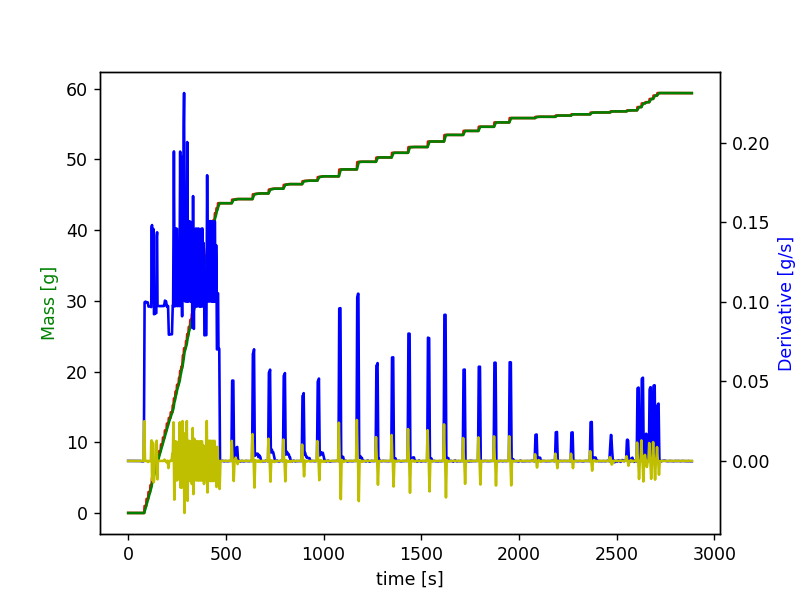

Addition of 0.593g Texapon SB 3 KC detected from 526s to 566s - expected volume = 0.725mL and actual volume = 0.532mL (resulting error is 26.621%)
Addition of 0.801g Plantacare 818 detected from 632s to 684s - expected volume = 0.915mL and actual volume = 0.729mL (resulting error is 20.259%)
Addition of 0.672g Plantacare 818 detected from 714s to 756s - expected volume = 0.565mL and actual volume = 0.619mL (resulting error is 9.601%)
Addition of 0.648g Plantacare 818 detected from 790s to 836s - expected volume = 0.565mL and actual volume = 0.596mL (resulting error is 5.575%)
Addition of 0.497g Plantacare 2000 detected from 886s to 936s - expected volume = 0.548mL and actual volume = 0.451mL (resulting error is 17.612%)
Addition of 0.615g Plantacare 2000 detected from 964s to 1010s - expected volume = 0.548mL and actual volume = 0.559mL (resulting error is 2.04%)
Addition of 0.983g Dehyton MC detected from 1074s to 1108s - expected volume = 0.982mL and actual volume = 0.907mL (resultin

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00025 g/s^2


<IPython.core.display.Javascript object>


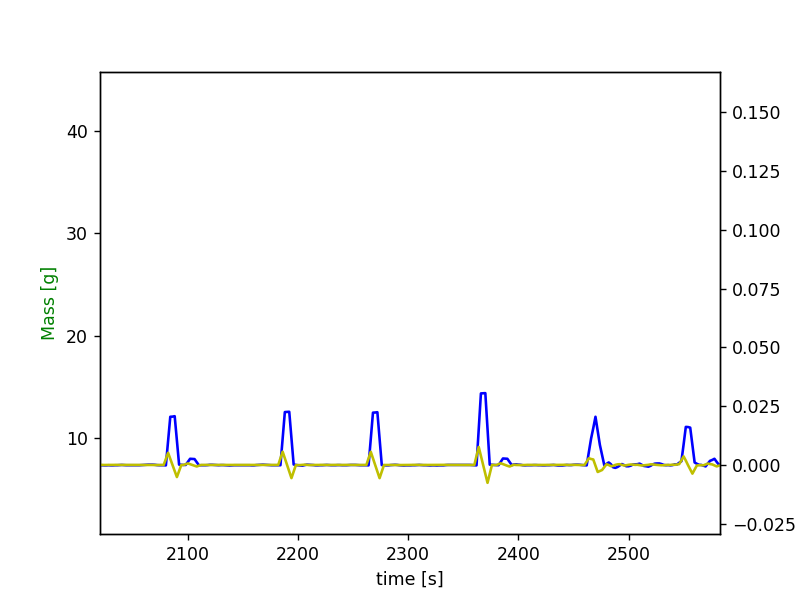

Addition of 0.184g Salcare Super 7 detected from 2078s to 2114s - expected volume = 0.25mL and actual volume = 0.164mL (resulting error is 34.286%)
Addition of 0.18g Salcare Super 7 detected from 2182s to 2200s - expected volume = 0.093mL and actual volume = 0.162mL (resulting error is 74.757%)
Addition of 0.177g Salcare Super 7 detected from 2262s to 2280s - expected volume = 0.122mL and actual volume = 0.158mL (resulting error is 29.106%)
Addition of 0.265g Salcare Super 7 detected from 2360s to 2398s - expected volume = 0.267mL and actual volume = 0.237mL (resulting error is 11.329%)
Addition of 0.157g Salcare Super 7 detected from 2460s to 2496s - expected volume = 0.098mL and actual volume = 0.141mL (resulting error is 43.922%)
Addition of 0.141g Salcare Super 7 detected from 2518s to 2564s - expected volume = 0.114mL and actual volume = 0.128mL (resulting error is 11.607%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


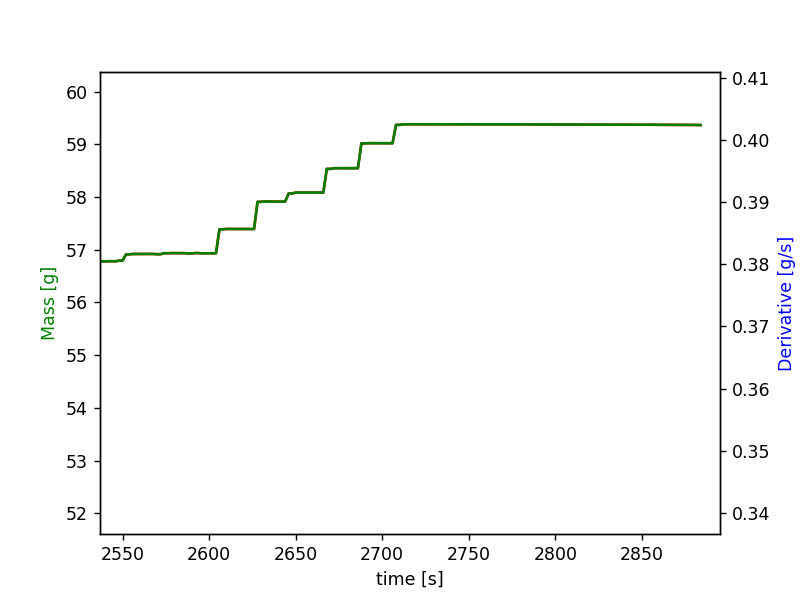

Addition of 0.016g Arlypon F detected from 2568s to 2578s - expected volume = 0.521mL and actual volume = 0.018mL (resulting error is 96.529%)
Addition of 0.462g Arlypon F detected from 2600s to 2612s - expected volume = 0.568mL and actual volume = 0.527mL (resulting error is 7.229%)
Addition of 0.522g Arlypon F detected from 2622s to 2634s - expected volume = 0.167mL and actual volume = 0.588mL (resulting error is 252.703%)
Addition of 0.169g Arlypon F detected from 2640s to 2654s - expected volume = 0.503mL and actual volume = 0.192mL (resulting error is 61.91%)
Addition of 0.462g Arlypon F detected from 2662s to 2674s - expected volume = 0.516mL and actual volume = 0.523mL (resulting error is 1.429%)
Addition of 0.476g Arlypon F detected from 2682s to 2694s - expected volume = 0.379mL and actual volume = 0.546mL (resulting error is 43.807%)


In [8]:
# default bl_mult = 1, default mergeSens = 1
#t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_050623_S559-S564.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_22972\26829907.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
558,559.0,0.0,0.000000,0.000000,0.000000,8.105263,0.000000,0.0,10.64829,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.662352,1.160066,0.0
559,560.0,0.0,0.000000,0.000000,0.000000,13.958508,8.347157,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.270816,5.087809,0.0
560,561.0,0.0,12.767663,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,8.039593,0.0,0.0,0.0,1.241698,3.773183,0.0
561,562.0,0.0,0.000000,6.767815,0.000000,0.000000,0.000000,0.0,0.00000,0.0,13.438222,0.0,0.000000,0.0,0.0,0.0,2.733254,3.987633,0.0
562,563.0,0.0,0.000000,11.973119,9.933769,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.604547,1.940609,0.0
563,564.0,0.0,12.054074,0.000000,0.000000,0.000000,8.629423,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.654928,1.133157,0.0
